<a href="https://colab.research.google.com/github/tr-dev-bc/Modern_CV_Assignments/blob/main/midterm24_step_4_and5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 4

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt         # used to plot error later
# helps running in jupyter
%matplotlib inline

from torchvision import datasets

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"         # switch for gpu else cpu

# load and normalize the fmnist dataset
data_folder = '~/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [19]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255) # Normalizes images to [0,1]
        x = x.view(-1,1, 28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]  # unpack tuple into variables
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [20]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=64, shuffle=True)         # batch size is 64
    return trn_dl
    #The DataLoader class in PyTorch loads dataset data, cuts it into batches, shuffles it

In [17]:

from torch.optim import SGD # based below on Chapter04/CNN_on_FashionMNIST.ipynb
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            # A convolutional layer with 32 filters, kernel size of 3, and stride of 1
            self.conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)  # added to process images, 1 channel for grayscale
            # A max-pooling layer with a kernel size of 2
            self.pool = nn.MaxPool2d(kernel_size=2)  # downsampling feature maps
            self.flatten = nn.Flatten()  # convert feature map to single D tensor
            # Flatten layer to connect the convolutional layers to the fully connected layers
            self.input_to_hidden_layer = nn.Linear(32 * 13 * 13, 128)  # changed input size after conv and pool
            self.batch_norm = nn.BatchNorm1d(128)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv_layer(x)
            x = self.pool(x)
            x = self.flatten(x)
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.hidden_to_output_layer(x1)
            return x2

    model = neuralnet().to(device)  # moves to the GPU to make it faster
    loss_fn = nn.CrossEntropyLoss()  # required cross-entropy loss function
    optimizer = SGD(model.parameters(), lr=1e-2)  # model.parameters() retrieves all the parameters of the model that need to be optimized.
    return model, loss_fn, optimizer

In [16]:
# loading up traiing data
train_loader = get_data()
model, loss_fn, optimizer = get_model()

# training loop with tracking of loss
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(x)
        loss = loss_fn(predictions, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

Epoch 1/10, Loss: 0.5211
Epoch 2/10, Loss: 0.3505
Epoch 3/10, Loss: 0.3023
Epoch 4/10, Loss: 0.2681
Epoch 5/10, Loss: 0.2428
Epoch 6/10, Loss: 0.2212
Epoch 7/10, Loss: 0.2033
Epoch 8/10, Loss: 0.1863
Epoch 9/10, Loss: 0.1710
Epoch 10/10, Loss: 0.1595


PLOT OF LOSS:

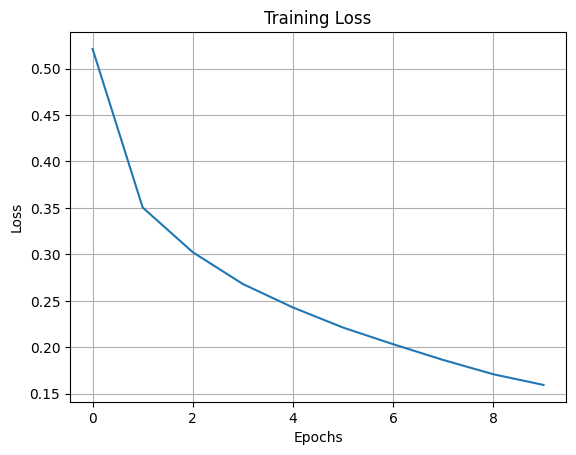

In [21]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()